## Imports

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model
from tensorflow.keras import regularizers

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2
import os
import time
import sys

import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model
import pandas as pd
import pickle

In [2]:
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score, mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score
import tensorflow as tf
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from scipy.io import savemat
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook


def scheduler1(step = 10, ratio = 1.2):
  def scheduler(epoch, lr):
    if epoch % step == 0 and epoch>1:
      return lr/ratio
    else:
      return lr
  return scheduler




def evaluation_metrics(y_true, y_pred, print_result=True):
    acc = 0
    auc = 0
    auc_sk = 0
    #mi = 0
    nmi = 0
    #ami = 0
    bacc = 0
    
    # Accuracy
    #report = classification_report(y_pred.argmax(axis=1), y_true.ravel(), output_dict=True)
    acc = accuracy_score( y_true.ravel(), y_pred.argmax(axis=1))  #report['accuracy']
    
    # Balanced accuracy
    bacc = balanced_accuracy_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze(), adjusted=True)
    
   # # Mutual Information
   # mi = mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # Normalized Mutual Information
    nmi = normalized_mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # Adjusted Mutual Information
    #ami = adjusted_mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # AUC (Tensorflow)
    auc_metric = tf.keras.metrics.AUC(from_logits=True)
    auc_metric.update_state(y_true, y_pred.argmax(axis=1).astype('float'))
    auc = auc_metric.result().numpy()
    auc_metric.reset_states()
    
    # AUC (scikit-learn)
    auc_sk = roc_auc_score(ook(y_true), y_pred)
    
    if print_result:
        print("Accuracy: {:.4f}".format(acc))
        print("Balanced Accuracy: {:.4f}".format(bacc))
        print("Mutual Information: {:.4f}".format(mi))
        print("Normalized Mutual Information: {:.4f}".format(nmi))
        print("Adjusted Mutual Information: {:.4f}".format(ami))
        print("AUC (Tensorflow): {:.4f}".format(auc))
        print("AUC (scikit-learn): {:.4f}".format(auc_sk))
    
    return acc, auc, auc_sk, nmi, bacc   # mi, , ami


# Multiple annotators model

In [3]:
#cargar datos desde drive acceso libre 
FILEID = "1zIcnmybob9XUBExCXzhCvqKkVgg4Qw5L"
#https://drive.google.com/file/d/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW/view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O Cifar-10H.zip && rm -rf /tmp/cookies.txt
!unzip -o Cifar-10H.zip
!dir

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-02-15 06:55:38--  https://docs.google.com/uc?export=download&confirm=t&id=1zIcnmybob9XUBExCXzhCvqKkVgg4Qw5L
Resolving docs.google.com (docs.google.com)... 74.125.196.113, 74.125.196.102, 74.125.196.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.196.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mlgfcs18lke32qp6kuqr6vnc2h12e8if/1676444100000/07591141114418430227/*/1zIcnmybob9XUBExCXzhCvqKkVgg4Qw5L?e=download&uuid=b623db64-40fb-4bed-91e0-9f38a060e8cd [following]
--2023-02-15 06:55:39--  https://doc-08-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mlgfcs18lke32qp6kuqr6vnc2h12e8if/1676444100000/07591141114418430227/*/1zIcnmybob9XUBExCXzhCvqKkVgg4Qw5L?e=download&uuid=b623db64-40fb-4bed-91e0-9f38a060e8cd
Resolvi

In [4]:
Data_dir = '/kaggle/working/Cifar-10H/test_batch'
labels_dir = '/kaggle/working/Cifar-10H/Answers_Processed.csv'

In [5]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [6]:
def arr_to_im(X):
  N = X.shape[0]
  X_tr = np.zeros((N,32,32,3))
  for i,x in enumerate(X):
    aux = x.reshape(3,32,32)/255
    aux = aux.transpose(1,2,0)
    X_tr[i,:] = cv2.resize(aux, (32,32))
  return X_tr

In [7]:
X = unpickle(Data_dir)[b'data']
Label = pd.read_csv(labels_dir, header=None)
Label = Label.to_numpy()
Y = Label[:,:-1]
y = Label[:,-1][:,np.newaxis]
N, R = Y.shape
K = len(np.unique(y))
# y = Label[:,np.newaxis]

In [8]:
# Se eliminan las muestras que no fueron etiquetadas por ningun anotador
idx_ = np.sum(Y,axis=1) != R*(-999)
X = X[idx_,:]
Y = Y[idx_,:]
N, R = Y.shape
y = y[idx_,:]
X = arr_to_im(X)

## Test data

In [9]:
Test_dir = '/kaggle/working/Cifar-10H/data_batch_1'

In [10]:
X_te = unpickle(Test_dir)[b'data']
X_te = arr_to_im(X_te)
y_te = np.array(unpickle(Test_dir)[b'labels'])[:,np.newaxis]

In [11]:
train_batchesMA = tf.data.Dataset.from_tensor_slices((X,y, Y))
train_batchesMA = train_batchesMA.shuffle(1024).batch(64)

In [12]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
#tf.random.set_seed(42)
import types
import tempfile
class Keras_MA_RCDNN(): #transformer no va
 #Constructor __init__. Special method: identified by a double underscore at either side of their name
 #work in the background
 # initialize data members to the object. lets the class initialize the object’s attributes and serves no other purpose.
    def __init__(self,epochs=100,batch_size=30,R=5, K=2, dropout=0.5, learning_rate=1e-3,optimizer='Adam', 
                  l1_param=0, validation_split=0.3, verbose=1, q = 0.1):
        self.epochs=epochs
        self.dropout=dropout
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l1_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.R=R
        self.K=K
        self.q = q

    
 
    def custom_RCDNN_loss(self, y_true, y_pred):  #ytrue \in N x R,  ypred \in N x (R+K) -> PRI->JULI
    
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 

        #Ground truth estimation samples (N) x  Classes(K)
        pred = y_pred[:,self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1-1e-9) #estabilidad numerica de la funcion de costo
        # Annotators reliability prediction: samples (N) x  annotators (R)
        ann_ = y_pred[:,:self.R]
        #Y_true 1-K: samples (N) x  Classes(1-K), annotators (R)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)
        #loss computation
        p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
        temp1 = ann_*tf.math.log(p_logreg)  
        temp2 = (1 - ann_)*tf.math.log(1/self.K)*tf.reduce_sum(Y_true,axis=1)
        # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
        # print(tf.reduce_mean(Y_true,axis=1).numpy())
        return -tf.math.reduce_sum((temp1 + temp2))

        
    def GCCE_MA_loss(self, y_true, y_pred):
        # print(y_true,y_pred)
       # q = 0.1
        pred = y_pred[:, self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
        ann_ = y_pred[:, :self.R]
        # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)

        p_gcce = Y_true*(1 - Y_hat**self.q)/self.q
        temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)

        # p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
        # temp1 = ann_*tf.math.log(p_logreg)  
        # temp2 = (1 - ann_)*tf.math.log(1/K)*tf.reduce_sum(Y_true,axis=1)
        # aux = tf.repeat(tf.reduce_sum(pred*tf.math.log(pred),axis=1,keepdims=True), R, axis = 1)
        # tf.print(tf.shape(aux))
        # print(tf.shape(aux))
        # temp2 = (1 - ann_)*aux*tf.reduce_sum(Y_true,axis=1)
        # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
        # print(tf.reduce_mean(Y_true,axis=1).numpy())
        # Y_true_1 = tf.clip_by_value(Y_true, clip_value_min=1e-9, clip_value_max=1)
        # p_logreg_inv = tf.math.reduce_prod(tf.math.pow(Y_true_1, Y_hat), axis=1)
        # temp2 = (1 - ann_)*tf.math.log(p_logreg_inv) 
        temp2 = (1 - ann_)*(1-(1/self.K)**self.q)/self.q*tf.reduce_sum(Y_true,axis=1)
        return tf.math.reduce_sum((temp1 + temp2))

 
    def PRI_MA_loss(self, y_true, y_pred): #,  -> PRI
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 
        #PRI MA
        cce_M = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=-1)
        cce_C = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=1)

      

        #N = tf.cast(y_true.shape[0],dtype=tf.int32)
        N = tf.shape(y_true)[0]
        #Ground truth estimation samples (N) x  Classes(K)
        y_pred_tf = y_pred[:,self.R:] 
        # Annotators reliability prediction: samples (N) x  annotators (R)
        lambda_R_tf = y_pred[:,:self.R] #tf.ones(shape=(N,R)) 
        #Y_true 1 K: samples (N) x  Classes(1-K), annotators (R)
        Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth=self.K,axis=1)  
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(y_pred_tf,-1), self.R, axis = -1) 
        #marginal entropy
        #cce along the K classes -> ypred_tf
        Hm_ = cce_M(y_pred_tf,y_pred_tf)
        #cross entropy
        #cce along the K classes -> Y_hat
        Hc_ = cce_C(Y_true_1K,Y_hat)
        #PRI MA computation
        LH = tf.linalg.matmul(lambda_R_tf,Hc_,transpose_a=True) # \Lambda^\top H_c
        temp1 = tf.linalg.trace(LH) #trace(LH)
        Hm1L = tf.linalg.matmul(tf.ones(shape=(N,self.R))-lambda_R_tf,tf.ones(shape=(self.R,1)))# 1_N 1_R^\top - Lambda
        Hm_t = tf.reshape(Hm_,shape=(N,1))
        temp2 = tf.squeeze(tf.linalg.matmul(Hm_t,Hm1L,transpose_a=True)) # Hm^\top Hm1L
        loss_c = temp1+ temp2 #return loss

        return loss_c

 
    def fit(self, X, Y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        P = X.shape[1]
        if self.optimizer == "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, clipnorm=1.0)
        elif self.optimizer == "SGD":
            opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate, clipnorm=1.0)
        else:
            opt=self.optimizer
         
        num_filters2 =32
        # Block 1
        input_l = tf.keras.layers.Input(shape=(32, 32, 3), name='entrada')
        x = keras.layers.Conv2D(num_filters2, (3, 3), activation="relu" , kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param, l2= self.l1_param),
                            name="block1_conv1")(input_l)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(num_filters2, (3, 3), activation="relu" , kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param, l2= self.l1_param),
                            name="block1_conv2")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.MaxPooling2D((2, 2),  name="block1_pool")(x)
        x = keras.layers.Dropout(self.dropout)(x)

#         x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu" , name="block1_conv1")(input_l)
#         x = tf.keras.layers.BatchNormalization()(x)
        # x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block1_pool")(x)



        # Block 2
        #x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(num_filters2*2, (3, 3), activation="relu", 
                                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param, l2= self.l1_param), name="block2_conv1")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(num_filters2*2, (3, 3), activation="relu", 
                                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param, l2= self.l1_param), name="block2_conv2")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.MaxPooling2D((2, 2),  name="block2_pool")(x)
        x = keras.layers.Dropout(self.dropout)(x)


         # Block 3
        #x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(num_filters2*4, (3, 3), activation="relu", 
                                kernel_regularizer= tf.keras.regularizers.l1_l2(l1=self.l1_param, l2= self.l1_param), name="block3_conv1")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(num_filters2*4, (3, 3), activation="relu", 
                                kernel_regularizer= tf.keras.regularizers.l1_l2(l1=self.l1_param, l2= self.l1_param), name="block3_conv2")(x)
        x = keras.layers.BatchNormalization()(x)
        #x = keras.layers.MaxPooling2D((2, 2), name="block2_pool")(x)
        x = keras.layers.Dropout(self.dropout)(x)

         
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(512,activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(self.dropout)(x)
        output = tf.keras.layers.Dense(self.K,activation="softmax", 
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param), name= 'out_K_GCCE')(x)
  
        self.model = tf.keras.Model(inputs= input_l,outputs=output)
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=opt)
        
 
        self.history = self.model.fit(X, Y, epochs=self.epochs, validation_split=self.validation_split,   #
                                      batch_size=self.batch_size,verbose=self.verbose)
 
        return self
 
  
    
    def predict(self, X, *_):
       #input X numpy array first dimension samples (N)x features (P)
      return  self.model.predict(X) 
 
 

    def fit_predict(self,X,y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        self.fit(X,y)
        return self.predict(X)
  
     #graphics
    def plot_history(self):
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.grid(True)
        #plt.gca().set_ylim(0, 1)
        #save_fig("keras_learning_curves_plot")
        plt.show()
        return
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self
    
    
    
    def get_params(self, deep=True):
        return { 'l1_param':self.l1_param, 'dropout':self.dropout, 'optimizer':self.optimizer,
                'learning_rate':self.learning_rate, 'batch_size':self.batch_size,
                'epochs':self.epochs, 'verbose':self.verbose, 'validation_split':self.validation_split,
                'R':self.R, 'K':self.K, 'q':self.q
                }

  
        return self


In [13]:
train_batches = tf.data.Dataset.from_tensor_slices((X,y))
test_batches = tf.data.Dataset.from_tensor_slices((X_te,y_te))

In [14]:
import numpy as np
from scipy import stats
Ytr_mv  = []

for i in range(Y.shape[0]):
     #print(Y_train[i])
     Ytr_mv   += [np.take(stats.mode(Y[i,Y[i] != -999]),0)]
     #print(mode_Y)
#Ytr_mv 

In [15]:
Ytr_mv = np.array(Ytr_mv )
Ytr_mv

array([3., 8., 0., ..., 5., 0., 7.])

## Build the classifier from multiple annotators

In [16]:

import tensorflow as tf
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from scipy.io import savemat
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook


def scheduler1(step = 10, ratio = 1.2):
  def scheduler(epoch, lr):
    if epoch % step == 0 and epoch>1:
      return lr/ratio
    else:
      return lr
  return scheduler

iteration: 0


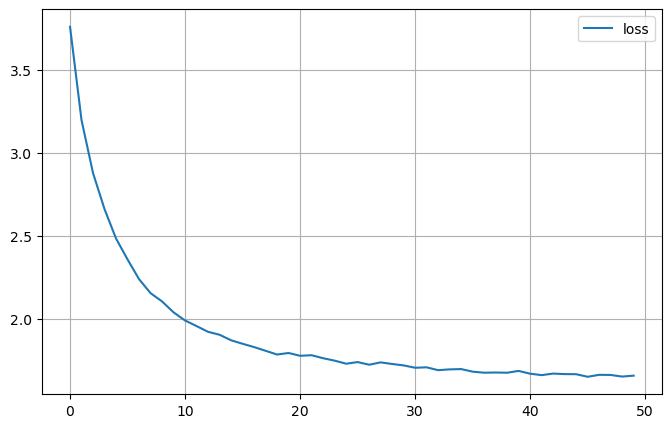

313/313 [==============================] - 1s 3ms/step
iteration: 1


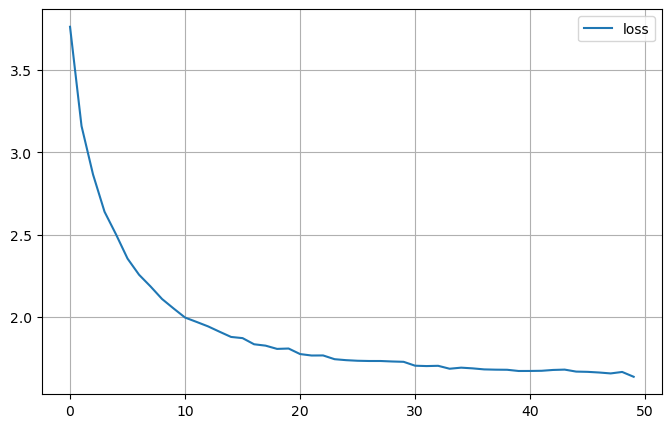

313/313 [==============================] - 1s 2ms/step
iteration: 2


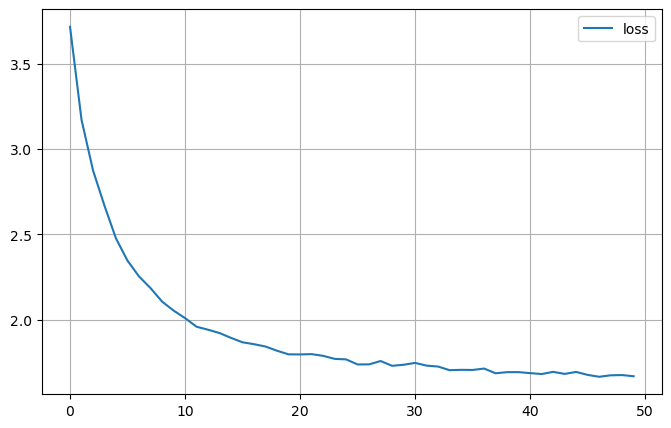

313/313 [==============================] - 1s 2ms/step
iteration: 3


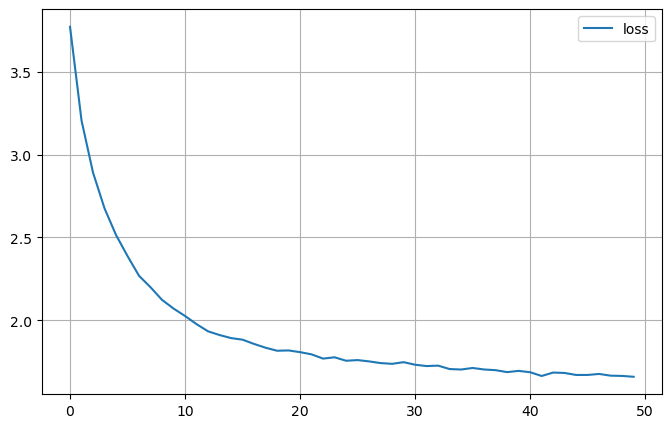

313/313 [==============================] - 1s 2ms/step
iteration: 4


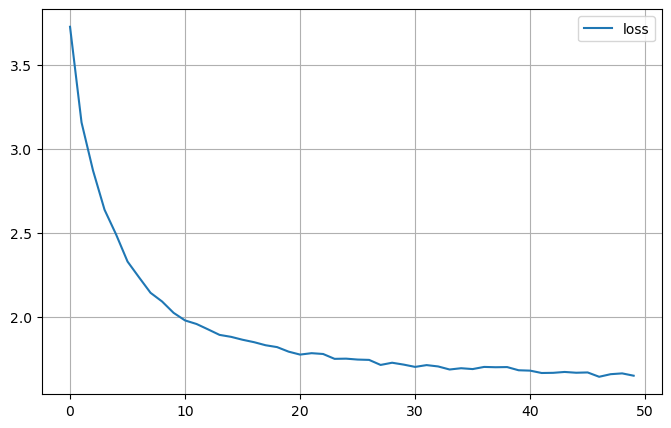

313/313 [==============================] - 1s 2ms/step
iteration: 5


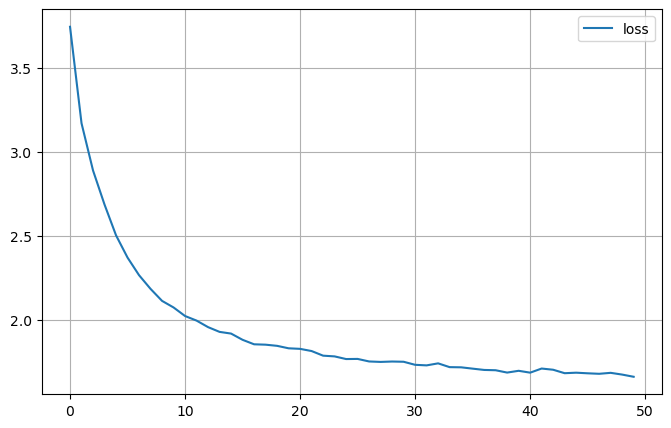

313/313 [==============================] - 1s 2ms/step
iteration: 6


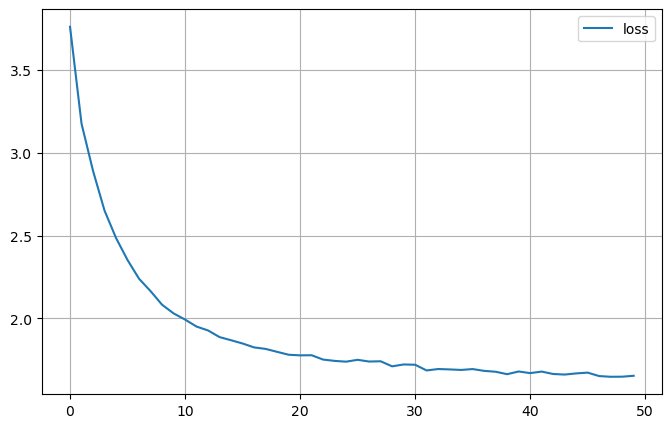

313/313 [==============================] - 1s 2ms/step
iteration: 7


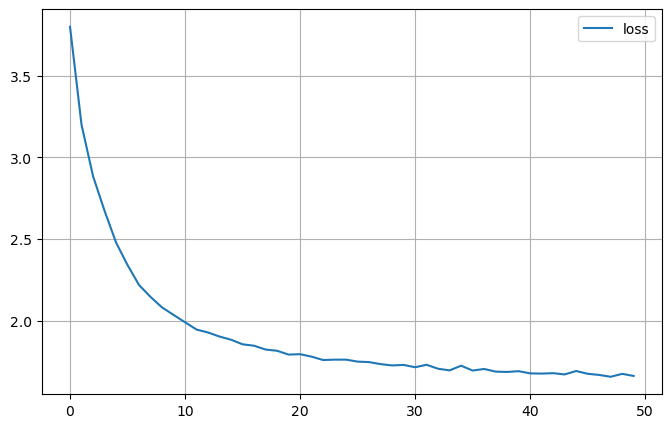

313/313 [==============================] - 1s 2ms/step
iteration: 8


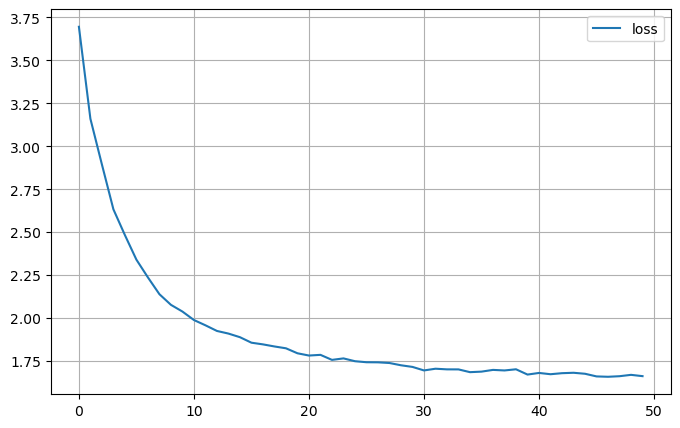

313/313 [==============================] - 1s 2ms/step
iteration: 9


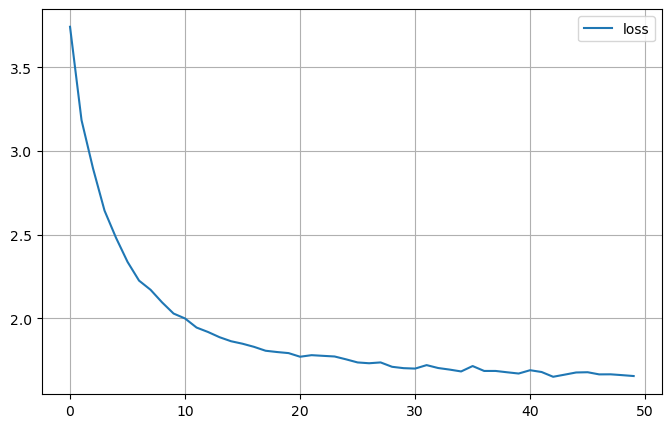

313/313 [==============================] - 1s 2ms/step


In [17]:
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
l1 =0.0001
NUM_RUNS =10

  
results = []
for i in range(NUM_RUNS):

    print("iteration: " + str(i))
   
    MA = Keras_MA_RCDNN(epochs=50,batch_size=64,R=Y.shape[1], K=len(np.unique(y)), dropout=0.5, learning_rate=0.001,optimizer='Adam', 
                l1_param=l1,  validation_split=0, verbose=0, q=0.01)

   
    MA.fit(X , Ytr_mv )
    MA.plot_history()
    #MA.plot_history()
  
    # Generate the predictions for the current run
    pred_2 = MA.predict(X_te)
    Y_true_test = y_te
     
    acc, auc, auc_sk,  nmi,  bacc = evaluation_metrics(Y_true_test,  pred_2, print_result=False)  # mi, ami,
    
    # Save the results for the current run to the list of dictionaries
    results.append({
        #'run': i,
        'accuracy': acc,
        'balanced_accuracy': bacc,
       # 'mutual_information': mi,
        'normalized_mutual_information': nmi,
     #   'adjusted_mutual_information': ami,
        'auc_tensorflow': auc,
        'auc_scikit_learn': auc_sk,
    })
    
# Convert the list of dictionaries to a DataFrame
df = np.round(pd.DataFrame(results)*100, 2)

# Calculate the mean and standard deviation of each metric
mean = np.round(df.mean(),2)
std = np.round(df.std(),2)  


In [18]:
df

,accuracy,balanced_accuracy,normalized_mutual_information,auc_tensorflow,auc_scikit_learn
0,67.58,63.92,47.96,82.860001,94.44
1,68.87,65.33,50.11,84.750000,94.82
2,68.97,65.57,50.12,84.930000,95.09
3,67.63,64.16,49.78,78.660004,94.82
4,66.65,62.90,47.61,77.930000,94.25
5,68.77,65.25,50.65,83.459999,95.25
6,66.56,62.72,47.27,82.059998,94.35
7,69.00,65.55,50.61,77.099998,94.90
8,69.48,66.04,51.26,85.010002,95.18
9,68.89,65.42,50.12,83.019997,95.04


In [19]:
mean

accuracy                         68.24
balanced_accuracy                64.69
normalized_mutual_information    49.55
auc_tensorflow                   81.98
auc_scikit_learn                 94.81
dtype: float64

In [20]:
std

accuracy                         1.05
balanced_accuracy                1.18
normalized_mutual_information    1.40
auc_tensorflow                   3.00
auc_scikit_learn                 0.35
dtype: float64

In [21]:


result_df = pd.concat([mean.rename('Mean'), std.rename('Std')], axis=1)

result_df


,Mean,Std
accuracy,68.24,1.05
balanced_accuracy,64.69,1.18
normalized_mutual_information,49.55,1.40
auc_tensorflow,81.98,3.00
auc_scikit_learn,94.81,0.35


In [22]:

# # Save the DataFrame to an excel file
# result_df.to_excel(database + custom_loss + ".xlsx")